In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras import backend as K
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [48]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [49]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [50]:
data.tail()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,2.81,3.08,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,2.84,3.12,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,2.87,3.15,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,2.84,3.14,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,2.91,3.22,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7931 non-null object
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null object
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(6), object(2)
memory usage: 557.6+ KB


In [52]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [53]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [54]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [55]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [56]:
data.columns

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [57]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [58]:
look_back = 10
time_steps = 10
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),...,var7(t+8),var8(t+8),var1(t+9),var2(t+9),var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9)
7917,2923.429932,2.82,3.05,85.629997,1204.699951,1.3891,113.660004,0.7702,2925.510010,2.85,...,111.650002,0.7797,2641.250000,2.81,3.08,77.559998,1230.800049,1.4136,112.489998,0.7808
7918,2925.510010,2.85,3.15,85.449997,1201.199951,1.4010,114.190002,0.7696,2901.610107,2.87,...,112.489998,0.7808,2682.629883,2.84,3.12,75.680000,1225.400024,1.4061,112.760002,0.7855
7919,2901.610107,2.87,3.19,86.070000,1203.449951,1.4128,113.790001,0.7684,2885.570068,2.88,...,112.760002,0.7855,2711.739990,2.87,3.15,74.839996,1214.949951,1.4104,112.860001,0.7825
7920,2885.570068,2.88,3.23,85.120003,1203.800049,1.4188,113.559998,0.7633,2884.429932,2.88,...,112.860001,0.7825,2740.370117,2.84,3.14,71.250000,1231.150024,1.3910,112.790001,0.7708
7921,2884.429932,2.88,3.22,84.220001,1186.949951,1.4144,113.345001,0.7622,2880.340088,2.88,...,112.790001,0.7708,2723.060059,2.91,3.22,71.110001,1232.099976,1.3891,113.089996,0.7713


In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [60]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [61]:
# split into input and outputs
train_X, train_y = train[:, :-8 * time_steps], train[:, -8 * time_steps:]
test_X, test_y = test[:, :-8 * time_steps], test[:, -8 * time_steps:]

In [62]:
train_X.shape

(3644, 80)

In [63]:
train_y.shape

(3644, 80)

In [64]:
train_X = train_X.reshape((train_X.shape[0], look_back, number_of_variables))
test_X = test_X.reshape((test_X.shape[0], look_back, number_of_variables))
train_y = train_y.reshape((train_y.shape[0], time_steps, number_of_variables))
test_y = test_y.reshape((test_y.shape[0], time_steps, number_of_variables))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3644, 10, 8) (3644, 10, 8) (1563, 10, 8) (1563, 10, 8)


# Building the Model

In [65]:
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return 0.5 * K.mean(loss, axis=-1) + 0.5 * K.std(loss, axis=-1)

In [66]:
def richy(y_true, y_pred):
    var_diff = K.var(y_true) - K.var(y_pred)
    abs_diff_ratio = K.mean(K.square(y_true/K.abs(y_true)- (y_pred/K.abs(y_pred))))
    return 0.5*var_diff + 0.5*abs_diff_ratio

In [67]:
model = Sequential()

model.add(LSTM(
    input_shape=(look_back,8),
    return_sequences=True, units=50))
#model.add(Dropout(0.2))

model.add(LSTM(
    250,
    return_sequences=True))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(8, activation = 'linear')))
#model.add(Activation("linear"))

from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('market_lstm_model_multiprediction')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]

#model.compile(loss="mse", optimizer="adam")
#model.compile(loss=stock_loss, optimizer="adam")
model.compile(loss=richy, optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 50)            11800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 250)           301000    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 8)             2008      
Total params: 314,808
Trainable params: 314,808
Non-trainable params: 0
_________________________________________________________________


In [63]:
model = Sequential()

model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=100))
#model.add(Dropout(0.2))
#model.add(LSTM(units=100, return_sequences=True))
#model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(
    250,
    return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(8 * time_steps , activation='linear'))

from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('market_lstm_model_multipredictionv1')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]


model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 100)           43600     
_________________________________________________________________
lstm_6 (LSTM)                (None, 250)               351000    
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20080     
Total params: 414,680
Trainable params: 414,680
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_batch = 150
history = model.fit(train_X, train_y, epochs=50, batch_size=n_batch, validation_data=(test_X, test_y))#, callbacks = callbacks_list)

Train on 3644 samples, validate on 1563 samples
Epoch 1/50
3644/3644 [==============================] - 3s 806us/step - loss: nan - val_loss: nan
Epoch 2/50
3644/3644 [==============================] - 1s 391us/step - loss: nan - val_loss: nan
Epoch 3/50
3644/3644 [==============================] - 1s 394us/step - loss: nan - val_loss: nan
Epoch 4/50
3644/3644 [==============================] - 1s 385us/step - loss: nan - val_loss: nan
Epoch 5/50
3644/3644 [==============================] - 1s 395us/step - loss: nan - val_loss: nan
Epoch 6/50
3644/3644 [==============================] - 1s 386us/step - loss: nan - val_loss: nan
Epoch 7/50
3644/3644 [==============================] - 1s 388us/step - loss: nan - val_loss: nan
Epoch 8/50
3644/3644 [==============================] - 1s 379us/step - loss: nan - val_loss: nan
Epoch 9/50
3644/3644 [==============================] - 1s 383us/step - loss: nan - val_loss: nan
Epoch 10/50
3644/3644 [==============================] - 1s 383us/step

In [134]:
# multi_model = Sequential()
# multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
# multi_model.add(Dense(1))
# multi_model.compile(loss='mae', optimizer='adam')

# Callbacks
# from keras.callbacks import ModelCheckpoint

# weight_path="{}_weights.hdf5".format('market_lstm_model')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = False)
# callbacks_list = [checkpoint]


# multi_history = multi_model.fit(train_X, train_y, epochs=40, batch_size=150, validation_data=(test_X, test_y), 
#                                 verbose=1, shuffle=False)#, callbacks = callbacks_list)

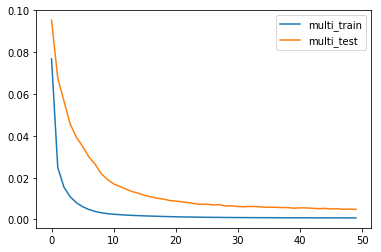

In [21]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [22]:
yhat = model.predict(test_X)

In [23]:
test_y.shape

(1563, 10, 8)

In [24]:
yhat.shape

(1563, 10, 8)

In [25]:
yhat[:,0]

array([[0.3026828 , 0.16999799, 0.24147272, ..., 0.3128305 , 0.26368815,
        0.32025   ],
       [0.29948705, 0.17062974, 0.2434426 , ..., 0.3167203 , 0.26718533,
        0.32596803],
       [0.29950595, 0.16874826, 0.24253905, ..., 0.3110468 , 0.26699463,
        0.3199796 ],
       ...,
       [0.8644726 , 0.2542038 , 0.15219061, ..., 0.6422821 , 0.2738447 ,
        0.6885151 ],
       [0.8577987 , 0.2565569 , 0.15598959, ..., 0.63833284, 0.2756902 ,
        0.6796134 ],
       [0.854201  , 0.25744766, 0.15644242, ..., 0.6360727 , 0.27446464,
        0.67569983]], dtype=float32)

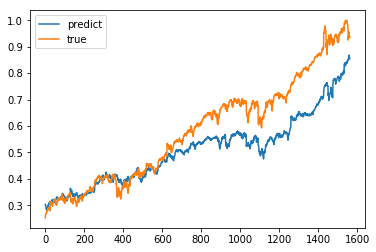

In [26]:
#pyplot.plot(yhat[:,0][:,0], label='predict')
#pyplot.plot(test_y[:,0][:,0], label='true')
pyplot.plot(yhat[:,0][:,0], label='predict')
pyplot.plot(test_y[:,0][:,0], label='true')
pyplot.legend()
pyplot.show()

In [27]:
test_X.shape

(1563, 10, 8)

In [28]:
test_y.shape

(1563, 10, 8)

In [29]:
#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
yhat = yhat.reshape((yhat.shape[0],yhat.shape[1] * yhat.shape[2]))

#yhat.shape

#yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

#test_X.shape

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

#inv_yhat.shape

inv_yhat = scaler.inverse_transform(inv_yhat)

#inv_yhat[:,-8:].shape

inv_yhat = inv_yhat[:,-8 * time_steps:]

#inv_yhat.shape

In [30]:
yhat.shape

(1563, 80)

In [31]:
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1] * test_y.shape[2]))

inv_y = concatenate((test_X[:, :], test_y), axis=1)

#inv_y.shape

inv_y = scaler.inverse_transform(inv_y)

#inv_y[:,-8:].shape

inv_y = inv_y[:,-8 * time_steps:]

#inv_y.shape

In [32]:
rmse = sqrt(mean_squared_error(test_y[:,0], yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.105


In [33]:
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 282.948


In [34]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart, actual_chart])

In [42]:
inv_y.shape

(1563, 80)